## Rainfall Prediction over Michigan Lake using CNN and RNN
-----------------------------
**Notoebook Summary**: *Due to the disparity in the dataset sizes between cloud data (with only 8 records per day) and meteorological data, integrating the features extracted from images with the meteorological data poses a challenge. It's unclear how to effectively combine the 8-record cloud information extracted from the CNN with the 24-record meteorological data from the RNN model. In this current notebook, we consider summarizing the day into a single record, by averaging the features and aggregating the Precip_in column*

In the current Notebook,

    * CNN Model Training ==> on Cloud data 
    * RNN Model Training ==> on Meteo data
    * Hybrid Model ==> Combinging both CNN + RNN Models
    * Applying a Dense layer after combining the CNN + RNN Models ==> to Predict one of the 3-classes: **No-Rain/Medium-Rain/High-Rain**

#### **Dataset**: Using Last **`3-days of CNN + RNN`** Data to **`Predict after 2 days`** Rain Class

#### Teammates:
    * Krishnakanth Naik Jarapala
    * Uday 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import pandas as pd
import numpy as np
import pickle
import ast


# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

* Load the Dataset

In [2]:
df = pd.read_csv('../../artifacts/data/recent_18_months_les_data_preprocessed_422.csv')
df = df.drop('Lake_data_1D', axis=1)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,48.0,93.0,800,4,992.7,0.05
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,48.0,93.0,800,4,993.3,0.05
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,49.0,89.0,600,6,993.0,0.04
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,48.0,87.0,1200,8,993.0,0.01
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,48.0,86.0,1000,10,993.7,0.00


* Data is not continuous, so lets create the sequence dataset by each window: [2014-10 - 2015-03] + [2015-10 - 2016-03] + [2016-10 - 2017-03]

In [3]:
mnts= df.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])

yr_mnt_lst

[['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03'],
 ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03'],
 ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']]

In [4]:
df['sequence_window'] = -1

for i, val in enumerate(yr_mnt_lst):
    df.loc[df.year_month.isin(val), 'sequence_window'] = i+1


df.sequence_window.value_counts()

sequence_window
2    4392
1    4368
3    4368
Name: count, dtype: int64

### Creating a new feature - day_session 

* 0-8 ==> day-session- 1
* 8-16 ==> day-session- 2
* 16-24 ==> day-session- 3


*Idea: Train a model on 3 records per day - where we select the max precip record from one of the 8-hour duration (day-session)*

In [5]:
df['day_session'] = df['Time_UTC'].apply(lambda x: (int(x[:2])//8))
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')

In [6]:
# Rank order the records of each 8-hour session by Precip values in Descending order
df['RN'] = df.sort_values(['date','day_session', 'Precip_in'], ascending=[True,True, False]).groupby(['date','day_session']).cumcount()+1

Computing the sum-of-precip each day

In [7]:
df['sum_precip_in'] = 0

for i in df.date.unique():
    df.loc[df.date == i, 'sum_precip_in'] = np.round(df[df.date == i].Precip_in.sum(), 6)

df.head()

C:\Users\jkkn7\AppData\Local\Temp\ipykernel_19624\578452082.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.date == i, 'sum_precip_in'] = np.round(df[df.date == i].Precip_in.sum(), 6)


,Date_UTC,Time_UTC,datetime,year_month,day_sin,day_cos,year_sin,year_cos,Wind_x,Wind_y,...,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Precip_in,sequence_window,day_session,date,RN,sum_precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,-1.331485e-12,1.000000,-0.999946,-0.010354,9.526279,-5.500000e+00,...,93.0,800,4,992.7,0.05,1,0,2014-10-01,1,0.15
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,2.588190e-01,0.965926,-0.999954,-0.009637,8.457234,-3.078181e+00,...,93.0,800,4,993.3,0.05,1,0,2014-10-01,2,0.15
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,5.000000e-01,0.866025,-0.999960,-0.008920,8.000000,-1.959435e-15,...,89.0,600,6,993.0,0.04,1,0,2014-10-01,3,0.15
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,7.071068e-01,0.707107,-0.999966,-0.008203,8.660254,5.000000e+00,...,87.0,1200,8,993.0,0.01,1,0,2014-10-01,4,0.15
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,8.660254e-01,0.500000,-0.999972,-0.007487,5.142301,6.128356e+00,...,86.0,1000,10,993.7,0.00,1,0,2014-10-01,5,0.15


---------------------------------------------------
### 2. Loading the Cloud-Images
*Load the Preprocessed Cloud-Images and select respective precip_in values from above data*

In [8]:
feats_req = ['datetime', 'date', 'year_month', 'Time_UTC', 'sum_precip_in']

images_df = df[(df['Time_UTC'] >= '14:00') & (df['Time_UTC'] <= '21:00')][feats_req].reset_index(drop=True)
print(f"Shape of the dataset: {images_df.shape}")

images_df.head()

Shape of the dataset: (4376, 5)


,datetime,date,year_month,Time_UTC,sum_precip_in
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15


In [9]:
from tqdm import tqdm
import cv2

images_array = []

# Load the 128, 128 images
g = '../../artifacts/lake_michigan_images_resized'

img_names = -1
for idx in tqdm(range(len(os.listdir(g)))):
    g_img = g + "/" + str(idx) + ".png"
    im = cv2.imread(g_img)
    # Storing 1 channel, since the images are grayscale, and cropping
    images_array.append(im[8:-8,8:-8,0]) # Crop the 8 pixel border

  0%|          | 0/4376 [00:00<?, ?it/s]

100%|██████████| 4376/4376 [00:00<00:00, 10856.70it/s]


Plot couple of sequence images from 0th Index

Displaying next frames starting at image 0.


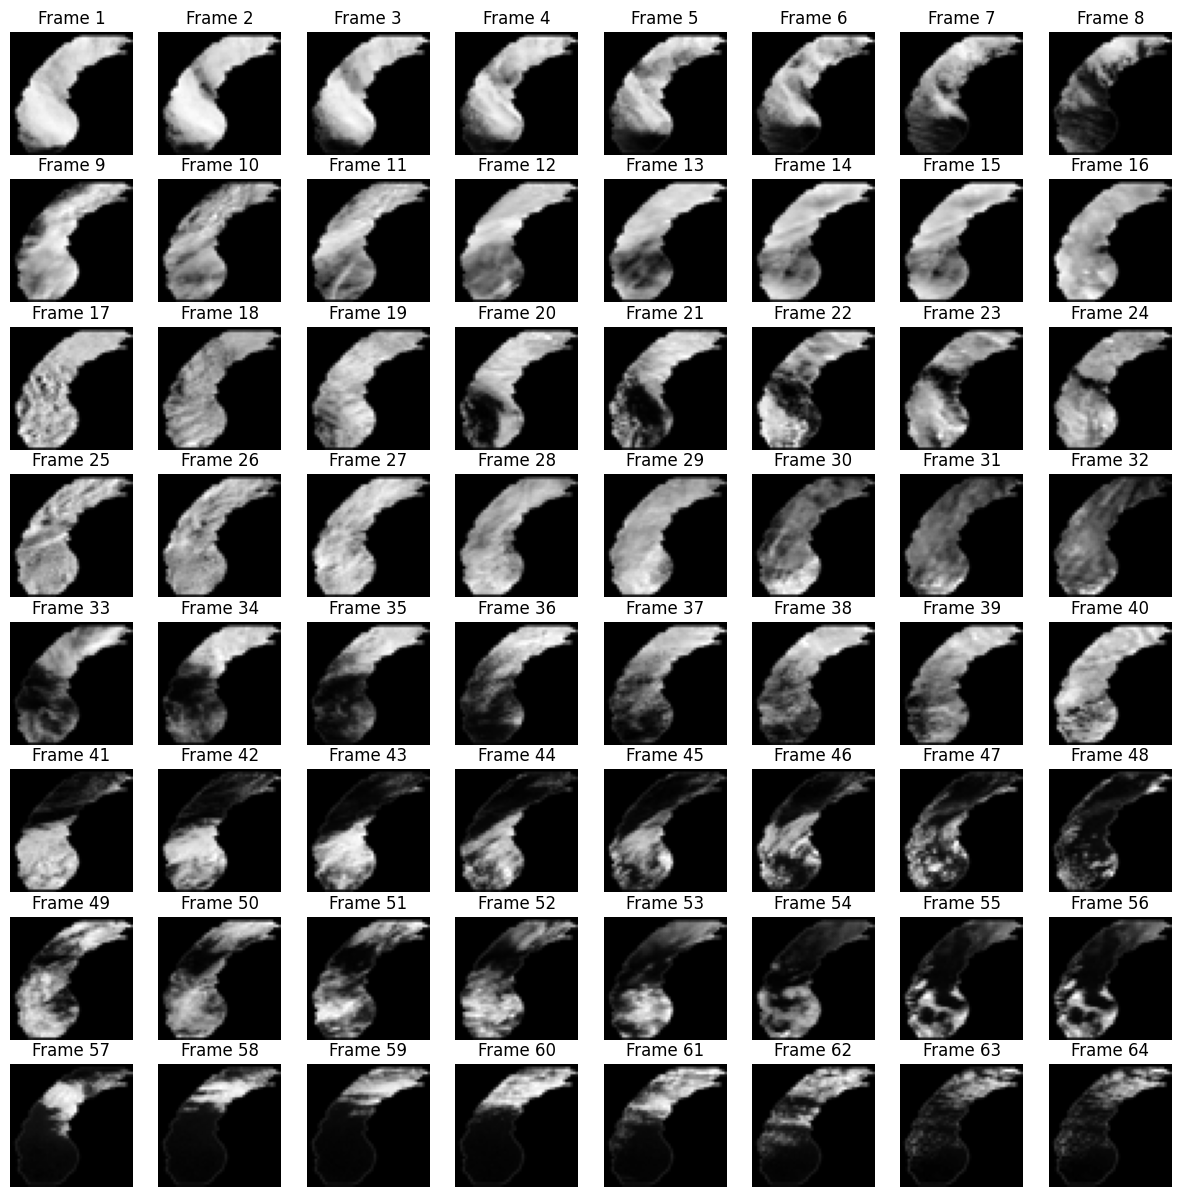

In [10]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(images)), size=1)[0]
data_choice = 0 # Start from 0th index
for idx, ax in enumerate(axes.flat):
    ax.imshow(images_array[data_choice + idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying next frames starting at image {data_choice}.")
plt.show()

In [11]:
images_df['image_array'] = images_array
images_df.head()

,datetime,date,year_month,Time_UTC,sum_precip_in,image_array
0,2014-10-01 14:00:00,2014-10-01,2014-10,14:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2014-10-01 15:00:00,2014-10-01,2014-10,15:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2014-10-01 16:00:00,2014-10-01,2014-10,16:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2014-10-01 17:00:00,2014-10-01,2014-10,17:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2014-10-01 18:00:00,2014-10-01,2014-10,18:00,0.15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


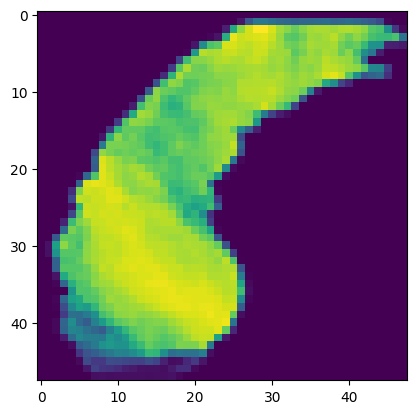

In [12]:
plt.imshow(images_df.image_array[0])

---------------------------------------------------
### 3. Creating the Day Level-data

In [13]:
# Group by date and calculate mean for feature1, feature2, feature3 and max for feature4, feature5
day_level_data = df.groupby(df['datetime'].dt.date).agg({
    'year_month':'first',
    'day_sin': 'mean',
    'day_cos': 'mean',
    'year_sin': 'mean',
    'year_cos': 'mean',
    'Temp_F': 'mean',
    'RH_pct': 'mean',
    'Low_Cloud_Ht_ft': 'mean',
    'Atm_Press_hPa': 'mean',
    'Wind_x': 'mean',
    'Wind_y': 'mean',
    'Visibility_mi': 'mean',
    'Precip_in': 'sum'
}).reset_index()

day_level_data.columns = ['date', 'year_month','day_sin', 'day_cos', 'year_sin', 'year_cos', 'Temp_F','RH_pct', 'Low_Cloud_Ht_ft', 'Atm_Press_hPa', 'Wind_x', 'Wind_y','Visibility_mi', 'sum_precip_in']
day_level_data['date'] = pd.to_datetime(day_level_data['date'])
day_level_data['date'] = day_level_data['date'].dt.strftime('%Y-%m-%d')
day_level_data.head()

,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01


### Classify the Precip into Rain-Classes:
        * 0 - No Rain
        * (0 - 0.06) - Med Rain
        * anything above 0.06 - High Rain

In [14]:
def classify_precip(val):
    high_rain_lower_limit = 0.06
    if val == 0:
        return "No_Rain"
    elif (val > 0) & (val <= high_rain_lower_limit):
        return "Medium_Rain"
    elif (val > high_rain_lower_limit):
        return "High_Rain"

In [15]:
day_level_data['rain_class'] = day_level_data['sum_precip_in'].apply(lambda x: classify_precip(x))
100*day_level_data.rain_class.value_counts(normalize=True)

rain_class
No_Rain        53.747715
High_Rain      23.217550
Medium_Rain    23.034735
Name: proportion, dtype: float64

In [16]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Assuming your class variable is named 'classes' and it is a list or array
classes = day_level_data['rain_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
label_binarizer = LabelBinarizer()
one_hot_encoded = label_binarizer.fit_transform(classes)

# Convert the one-hot encoded array to a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
day_level_data_with_one_hot = pd.concat([day_level_data, one_hot_df], axis=1)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:")
print(class_weights, class_weight_dict)

day_level_data_with_one_hot.head()

Class weights:
[1.43569554 1.44708995 0.62018141] {0: 1.4356955380577427, 1: 1.447089947089947, 2: 0.6201814058956916}


,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


#### Summary:
We have Day level, 8-hour session level and hourly data with the labels


    * df --- hourly and 8-hour session data
    * images_df --- CNN images data
    * day_level_data, day_level_data_with_one_hot --- day level data with agg-precip values

In [17]:
day_level_data_with_one_hot.head()

,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


* Create a images_df data daylevel by combinging all the images in particular day into 1 record

In [18]:
# List contains day-level-cloud-images
day_cloud_data_list = []

# Each day - combine all the images into a single list
for i in images_df.date.unique().tolist():
    day_cloud_data_list.append(images_df[images_df.date == i].image_array.tolist())

day_cloud_data_list = np.array(day_cloud_data_list)

day_cloud_data_list.shape, day_level_data.shape

((547, 8, 48, 48), (547, 15))

* Computing the Class-Weights

In [19]:
# Calculate the counts for each class
counts = {
    'no_rain': day_level_data_with_one_hot['No_Rain'].mean(),
    'medium_rain': day_level_data_with_one_hot['Medium_Rain'].mean(),
    'high_rain': day_level_data_with_one_hot['High_Rain'].mean()
}

# Calculate the probabilities for each class
total_counts = sum(counts.values())
probabilities = {k: v / total_counts for k, v in counts.items()}

# Calculate the initial bias for each class
# In this case, we use 'no_rain' as the reference class probability
reference_probability = probabilities['no_rain']
initial_biases = np.log([
    probabilities['high_rain'] / reference_probability,
    probabilities['medium_rain'] / reference_probability,
    probabilities['no_rain'] / probabilities['no_rain']]
    )

######################################################################### Bias

class_weights = {
    0: (1 / counts['high_rain']) * (total_counts / 3),
    1: (1 / counts['medium_rain']) * (total_counts / 3),
    2: (1 / counts['no_rain']) * (total_counts / 3)
}

######################################################################### Class Weights


print("Initial Biases:", initial_biases)
print("Class Weights:", class_weights)


Initial Biases: [-0.83939268 -0.84729786  0.        ]
Class Weights: {0: 1.4356955380577427, 1: 1.447089947089947, 2: 0.6201814058956916}


### Scale the RNN Data:

In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Windows - to select the dataset
train_data_windows = [1,2,3]

#cols to standardize
cols_to_standardize = ['year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 'Low_Cloud_Ht_ft',
    'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa']

TEST_Records = 0 # Number of Test data

# Train and Test datasets
rnn_train_df = day_level_data_with_one_hot.reset_index(drop=True)

print(f"Train Dataset shape: {rnn_train_df.shape}")

# Fit and transform the scaler on the Full data
rnn_train_df_scaled = rnn_train_df.copy()
rnn_train_df_scaled[cols_to_standardize] = scaler.fit_transform(rnn_train_df[cols_to_standardize])

Train Dataset shape: (547, 18)


In [21]:
rnn_train_df.shape, day_cloud_data_list.shape

((547, 18), (547, 8, 48, 48))

In [22]:
day_level_data_with_one_hot.iloc[0:2, 1].values[-1]

'2014-10'

### RNN Data Sequence Creation:

In [23]:
def create_sequences_rnn_cnn(data, cloud_data_list, feature_columns, label_columns, stride=0, past_time_steps=3, future_time_steps=1):
    X, y = [], []
    cnn_x = []
    
    for i in range(0, len(data) - past_time_steps - stride - future_time_steps + 1):
        X.append(data.iloc[i : (i + past_time_steps)][feature_columns].values.tolist())
        y.append(data.iloc[i + stride + past_time_steps : i + stride + past_time_steps + future_time_steps][label_columns].values[-1])

        cnn_x.append(cloud_data_list[(i + past_time_steps)])
    
    return np.array(X), np.array(y), np.array(cnn_x)

In [24]:
day_level_data_with_one_hot.head()

,date,year_month,day_sin,day_cos,year_sin,year_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Atm_Press_hPa,Wind_x,Wind_y,Visibility_mi,sum_precip_in,rain_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01,2014-10,6.738822e-14,9.456325e-14,-0.999985,-0.002111,55.666667,79.375000,5183.333333,993.000000,0.423936,1.821162,9.250000,0.15,High_Rain,1,0,0
1,2014-10-02,2014-10,3.391708e-13,-3.548550e-13,-0.999874,0.015091,58.708333,85.583333,3075.000000,988.687500,-1.583594,2.211282,6.250000,0.94,High_Rain,1,0,0
2,2014-10-03,2014-10,-3.720542e-13,-1.794861e-15,-0.999466,0.032289,56.000000,79.041667,3195.833333,978.737500,-0.675702,-6.158806,8.416667,0.81,High_Rain,1,0,0
3,2014-10-04,2014-10,6.795490e-15,-5.167626e-14,-0.998763,0.049477,49.166667,81.666667,2795.833333,977.262500,-2.718467,-3.856504,8.875000,0.49,High_Rain,1,0,0
4,2014-10-05,2014-10,3.598510e-13,9.454012e-14,-0.997764,0.066650,45.000000,68.791667,4120.833333,978.191667,-3.623998,-4.426348,9.916667,0.01,Medium_Rain,0,1,0


In [25]:
# Training data - creating Parameters
stride = 0                               # so skipping next day (1- records per day)
past_time_steps = 3 * 1                  # 3-days past
future_time_steps = 1 * 3                # 2-days in future (which is next to next date)

######################################################### 1

# 1. Creating the window of sequential data year-months
rnn_mnts= day_level_data_with_one_hot.year_month.unique().tolist()
rnn_yr_mnt_lst = []
for i in range(0, len(rnn_mnts), 6):
    # print(mnts[i: i+6])
    rnn_yr_mnt_lst.append(rnn_mnts[i: i+6])

######################################################### 2
### Sequence Training Data - Creating
data_x, data_y, cnn_data_x = [], [], []


feature_cols = ['day_sin','day_cos','year_sin','year_cos','Temp_F','RH_pct','Low_Cloud_Ht_ft','Atm_Press_hPa','Wind_x','Wind_y','Visibility_mi']
labels_cols = ['High_Rain', 'Medium_Rain', 'No_Rain']

# Creating the Sequence data for each window separately and then appending
for i in rnn_yr_mnt_lst:
    # x, y = prepare_data(train_df_scaled, i, cols_to_use, n_time_steps, future_steps)
    x, y, cnn_x = create_sequences_rnn_cnn(rnn_train_df[rnn_train_df.year_month.isin(i)], day_cloud_data_list, feature_cols, labels_cols, stride, past_time_steps, future_time_steps)
    # print(x.shape, y.shape)
    data_x.append(x)
    data_y.append(y)
    cnn_data_x.append(cnn_x)

######################################################### 3 - Train Dataset
# Concatenate the arrays along the first axis after the loop
rnn_x = np.concatenate(data_x, axis=0)
rnn_y = np.concatenate(data_y, axis=0)
cnn_x = np.concatenate(cnn_data_x, axis=0)

rnn_x.shape, rnn_y.shape, cnn_x.shape

((532, 3, 11), (532, 3), (532, 8, 48, 48))

In [27]:
# Reshape the shapes
cnn_train_x_reshaped = cnn_x.reshape((cnn_x.shape[0], cnn_x.shape[1], cnn_x.shape[2], cnn_x.shape[3], 1))

rnn_x.shape, rnn_y.shape, cnn_x.shape, cnn_train_x_reshaped.shape


((532, 3, 11), (532, 3), (532, 8, 48, 48), (532, 8, 48, 48, 1))

### Train, Test Data Split

In [28]:
Test_records = 50 # Last 50 records


## Training Data
rnn_train_x = rnn_x[:-Test_records]
rnn_train_y = rnn_y[:-Test_records]
cnn_train_x = cnn_train_x_reshaped[:-Test_records]

## Test Data
rnn_test_x = rnn_x[-Test_records:]
rnn_test_y = rnn_y[-Test_records:]
cnn_test_x = cnn_train_x_reshaped[-Test_records:]

rnn_train_x.shape, rnn_train_y.shape, cnn_train_x.shape, rnn_test_x.shape, rnn_test_y.shape, cnn_test_x.shape,

((482, 3, 11),
 (482, 3),
 (482, 8, 48, 48, 1),
 (50, 3, 11),
 (50, 3),
 (50, 8, 48, 48, 1))

### Hybrid Modelling:

In [29]:
from keras.models import Model
from keras.layers import Conv3D, MaxPooling3D, Concatenate, LSTM, Input

### Model 1: CNN with Conv3D Layer + 3 LSTM in RNN + with Class-Weights

In [30]:
# CNN Model
cnn_input = Input(shape=(8, 48, 48, 1))
cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn_input)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)

cnn = Flatten()(cnn)
cnn_output = Dense(32, activation='relu')(cnn)

# RNN Model
rnn_input = Input(shape=(3, 11))
rnn = LSTM(128, return_sequences=True)(rnn_input)
rnn = BatchNormalization()(rnn)
rnn = LSTM(64, return_sequences=True)(rnn)
rnn = BatchNormalization()(rnn)
rnn = LSTM(32, return_sequences=False)(rnn)
rnn = BatchNormalization()(rnn)
rnn_output = Dense(24, activation='relu')(rnn)

# Concatenation and final layers
concatenated = Concatenate()([cnn_output, rnn_output])

final_dense = Dense(32, activation='relu')(concatenated)
final_output = Dense(3, activation='softmax')(final_dense)

# Final model assembly
model = Model(inputs=[cnn_input, rnn_input], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
EPOCHS = 100
BATCH_SIZE = 32

# Define some callbacks to improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

history = model.fit(
    [cnn_train_x, rnn_train_x],
    rnn_train_y,                
    epochs= EPOCHS,                 
    batch_size= BATCH_SIZE,               
    # class_weight=class_weight_dict,
    validation_split=0.2,
    class_weight = class_weight_dict
    # callbacks=[early_stopping]    
)

Epoch 1/100
13/13 [==============================] - 6s 77ms/step - loss: 8.0304 - accuracy: 0.3429 - val_loss: 13.5197 - val_accuracy: 0.3196
Epoch 2/100
13/13 [==============================] - 0s 24ms/step - loss: 2.3870 - accuracy: 0.3688 - val_loss: 1.6295 - val_accuracy: 0.4124
Epoch 3/100
13/13 [==============================] - 0s 24ms/step - loss: 1.2167 - accuracy: 0.4078 - val_loss: 4.3393 - val_accuracy: 0.2165
Epoch 4/100
13/13 [==============================] - 0s 24ms/step - loss: 1.8065 - accuracy: 0.4156 - val_loss: 5.5129 - val_accuracy: 0.2062
Epoch 5/100
13/13 [==============================] - 0s 24ms/step - loss: 2.0957 - accuracy: 0.4416 - val_loss: 5.3526 - val_accuracy: 0.2165
Epoch 6/100
13/13 [==============================] - 0s 26ms/step - loss: 1.6821 - accuracy: 0.4519 - val_loss: 1.5623 - val_accuracy: 0.2577
Epoch 7/100
13/13 [==============================] - 0s 24ms/step - loss: 1.0732 - accuracy: 0.4416 - val_loss: 1.4418 - val_accuracy: 0.4742
Epoch

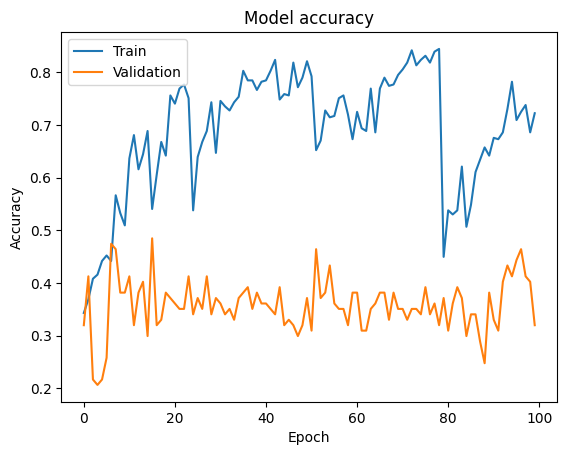

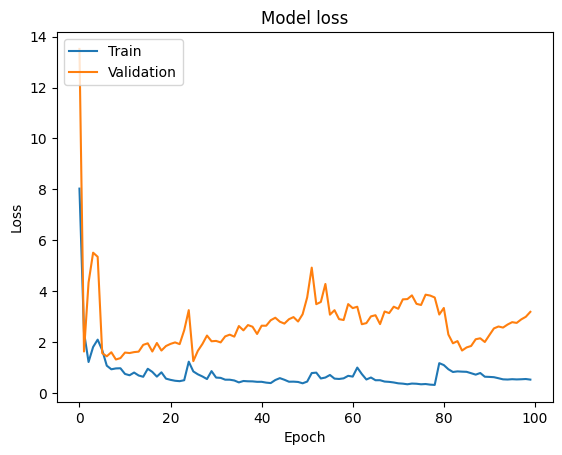

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the test dataset
pred_label = model.predict([cnn_test_x, rnn_test_x])

# Convert predictions from one-hot to labels
pred_label_cat = np.argmax(pred_label, axis=1)
true_label_cat = np.argmax(rnn_test_y, axis=1)

print(classification_report(true_label_cat.flatten(), pred_label_cat.flatten()))

2/2 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

           0       0.33      0.33      0.33        12
           1       0.25      0.38      0.30         8
           2       0.65      0.57      0.61        30

    accuracy                           0.48        50
   macro avg       0.41      0.42      0.41        50
weighted avg       0.51      0.48      0.49        50



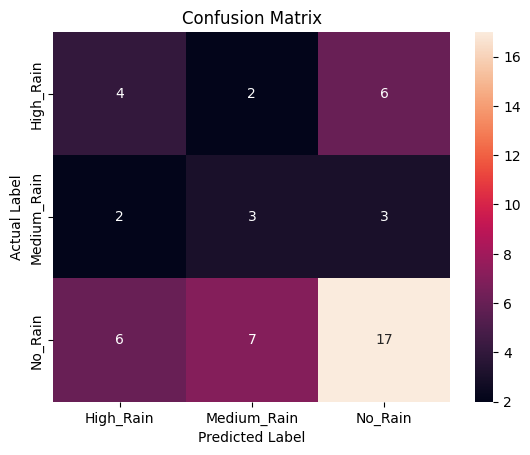

In [34]:
labels = day_level_data_with_one_hot.columns[-3:]

conmat = confusion_matrix(true_label_cat.flatten(), pred_label_cat.flatten())
sns.heatmap(conmat, annot=True, fmt='d',  xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### Model 2: CNN with Conv3D Layer + 3 LSTM in RNN + Dropout + with Class-Weights

In [35]:
# Define CNN input
cnn_input = Input(shape=(8, 48, 48, 1))

# CNN Model
cnn = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(cnn_input)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling3D(pool_size=(2, 2, 2))(cnn)
cnn = Dropout(0.20)(cnn)
cnn = Flatten()(cnn)
cnn_output = Dense(32, activation='relu')(cnn)

# Define RNN input
rnn_input = Input(shape=(3, 11))

# RNN Model
rnn = LSTM(128, return_sequences=True, activation='relu')(rnn_input)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.30)(rnn)
rnn = LSTM(64, return_sequences=True, activation='relu')(rnn)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.20)(rnn)
rnn = LSTM(32, return_sequences=False, activation='relu')(rnn)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.10)(rnn)
rnn_output = Dense(24, activation='relu')(rnn)

# Concatenate CNN and RNN outputs
concatenated = Concatenate()([cnn_output, rnn_output])

# Final dense layers
final_dense = Dense(32, activation='relu')(concatenated)
final_output = Dense(3, activation='softmax')(final_dense)

# Model assembly
model_with_dropout = Model(inputs=[cnn_input, rnn_input], outputs=final_output)

# Compile the model
model_with_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_with_dropout.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3, 11)]      0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 3, 128)       71680       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 3, 128)      512         ['lstm_3[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 dropout_1 (Dropout)            (None, 3, 128)       0           ['batch_normalization_5[0][

In [36]:
EPOCHS = 100
BATCH_SIZE = 32

# Define some callbacks to improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

history_model_with_dropout = model_with_dropout.fit(
    [cnn_train_x, rnn_train_x],
    rnn_train_y,                
    epochs= EPOCHS,                 
    batch_size= BATCH_SIZE,               
    validation_split=0.2,
    class_weight = class_weight_dict,
    callbacks=[early_stopping]    
)

Epoch 1/100
13/13 [==============================] - 3s 71ms/step - loss: 23.6045 - accuracy: 0.3922 - val_loss: 12.5715 - val_accuracy: 0.4845
Epoch 2/100
13/13 [==============================] - 0s 36ms/step - loss: 7.0283 - accuracy: 0.2987 - val_loss: 4.5279 - val_accuracy: 0.3711
Epoch 3/100
13/13 [==============================] - 0s 35ms/step - loss: 4.1362 - accuracy: 0.4883 - val_loss: 6.0742 - val_accuracy: 0.3196
Epoch 4/100
13/13 [==============================] - 0s 35ms/step - loss: 2.3157 - accuracy: 0.4182 - val_loss: 2.1514 - val_accuracy: 0.4948
Epoch 5/100
13/13 [==============================] - 0s 35ms/step - loss: 1.1434 - accuracy: 0.4883 - val_loss: 1.6489 - val_accuracy: 0.4227
Epoch 6/100
13/13 [==============================] - 0s 35ms/step - loss: 1.0684 - accuracy: 0.5403 - val_loss: 1.3256 - val_accuracy: 0.4227
Epoch 7/100
13/13 [==============================] - 0s 36ms/step - loss: 0.8718 - accuracy: 0.5870 - val_loss: 2.1560 - val_accuracy: 0.2062
Epoc

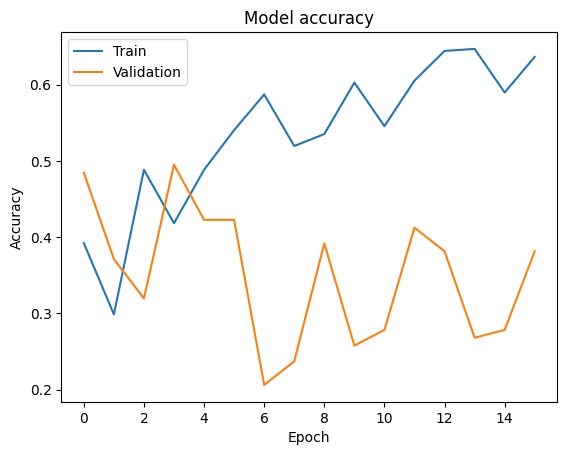

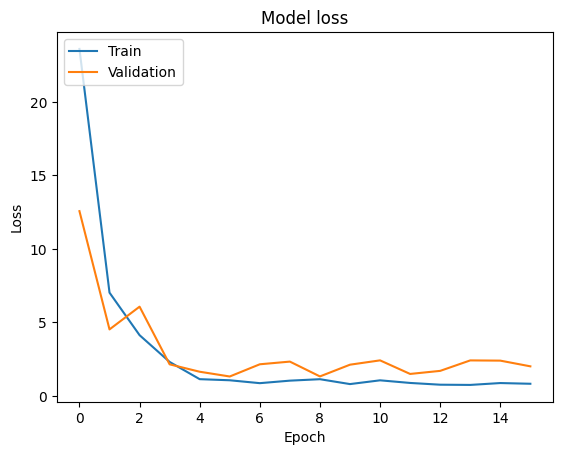

In [37]:
# Plot training & validation accuracy values
plt.plot(history_model_with_dropout.history['accuracy'])
plt.plot(history_model_with_dropout.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model_with_dropout.history['loss'])
plt.plot(history_model_with_dropout.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
# Predict the test dataset
pred_label = model_with_dropout.predict([cnn_test_x, rnn_test_x])

# Convert predictions from one-hot to labels
pred_label_cat = np.argmax(pred_label, axis=1)
true_label_cat = np.argmax(rnn_test_y, axis=1)

print(classification_report(true_label_cat.flatten(), pred_label_cat.flatten()))

2/2 [==============================] - 0s 57ms/step
              precision    recall  f1-score   support

           0       0.27      0.25      0.26        12
           1       0.50      0.12      0.20         8
           2       0.59      0.73      0.66        30

    accuracy                           0.52        50
   macro avg       0.46      0.37      0.37        50
weighted avg       0.50      0.52      0.49        50



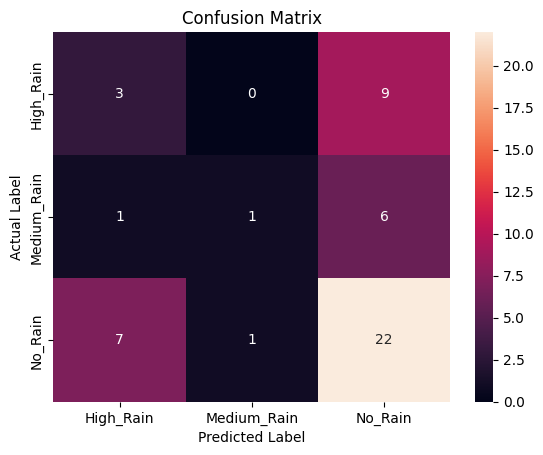

In [39]:
conmat = confusion_matrix(true_label_cat.flatten(), pred_label_cat.flatten())
sns.heatmap(conmat, annot=True, fmt='d',  xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### Summary:

* Both models show limitations in effectively predicting minority classes (0 and 1), as indicated by low precision, recall, and F1-score for these classes.
* Model 1 demonstrates slightly better performance in terms of precision, recall, and F1-score for class 0 and 1 compared to Model 2.
* However, Model 2 outperforms Model 1 in terms of overall accuracy due to its higher performance on the majority class (class 2).


### Compare to model which was predicting the very next day:
* Compare to earlier model, the current model accuracy dropped by a little but Interestingly the recall values among class - 0/1 are improved by a little